## 1 - Initial analysis of the cropped Quotebank dataset

We have filtered out all the rows corresponding to quotes that did not contain any of the keywords related to gun control. The remaining rows have been added to a new file: 'quotes-cropped.json', which will be one of our main datasets for this project. It is much more reasonnable in size (550 Mo) than the full Quotebank dataset. This will allow us to work with Jupyter lab with all the data we need.

In [1]:
#Import usefull libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Disable some pandas warnings we don't need
pd.options.mode.chained_assignment = None

# New dataframe with the data ('quotes-cropped.jspon')
df_original = pd.read_json('quotes-cropped.json', lines=True)

We will start by plotting the number of quotes containing at least one of our keywords over time (i.e. between 2015 and 2020). Even though some quotes will be irrelevant (e.g. "we were **shooting** a movie"), we assume the distribution of these irrelevant quotes to be close to uniform for the moment.

Our plot should therefore give a good first impression on how much people/the media has been speaking about gun control during these five years.

In [2]:
# Keep only the columns that we need for our initial analysis
df = df_original[['date','quotation']]

# Convert data column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort dataframe by date
df = df.sort_values(by=['date'])

df.head()

,date,quotation
65127,2015-01-01 00:07:32,When we are face a suspect holding one of thes...
77653,2015-01-01 00:08:12,I expect much of the same from Edinburgh at Mu...
97745,2015-01-01 00:13:41,Of course the negative is if you need your gun...
45716,2015-01-01 00:13:41,"Me personally, being a mother, when I sell a g..."
79888,2015-01-01 00:14:39,"We had a very good first half, and I thought w..."


Now that we have sorted the dataframe by date, we can move on to the plot.

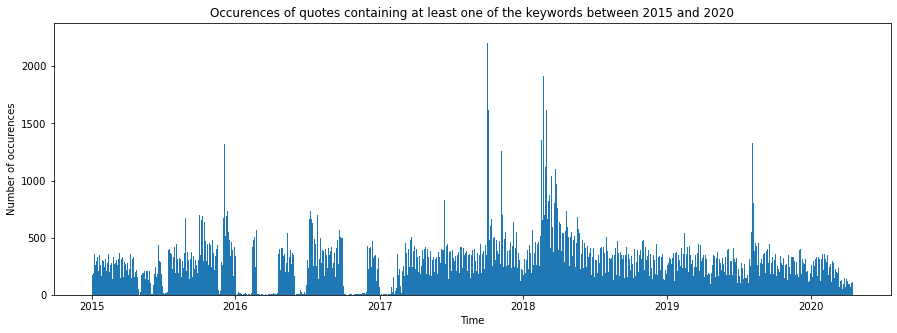

In [3]:
# Plotting number of quotes that contain keywords on the timeframe of the dataset
plt.figure(figsize=(15,5))

plt.hist(df['date'],bins=2000)

plt.title('Occurences of quotes containing at least one of the keywords between 2015 and 2020')
plt.xlabel('Time')
plt.ylabel('Number of occurences')
plt.show()

This histogram gives a good idea of how much people have been speaking of guns/firearms/shootings in the last 5 years in the media. But it has a major flaw: each quote has the same "weight" (one quote accounts for one occurence). But some quotes occure more often then others ('numOccurences' colum in the dataframe). We should take this extra information into account if we want a better view on the data.

In [4]:
# Define a new dataframe for this specific study
df = df_original[['date','numOccurrences']]
df.sample(n=15)

,date,numOccurrences
71982,2015-04-28 10:25:16,1
112725,2016-07-01 04:01:31,5
280027,2017-06-13 22:00:00,1
14099,2015-06-11 15:19:28,1
239186,2017-03-29 11:00:00,1
356896,2018-12-18 20:59:15,1
339149,2018-03-01 20:36:19,3
400117,2018-05-17 13:35:00,3
376789,2018-06-27 11:01:15,1
540531,2019-01-20 00:01:00,1


This sample shows well how some quotes can have very different number of occurences, and therefore highlights how important it is for us to take this parameter into account.

We will now define a new dataframe that contains the number of quotes (multiplied by their respective occurences) containing at least one of the keywords per day.

In [5]:
# We sum all the occurences of each date, and create a "sum" column in the dataframe
df = df['date'].dt.date.value_counts().rename('sum').to_frame()

# The dates are now the indices of the rows. We make them a column again.
df.index.name = 'date'
df.reset_index(inplace=True)

# Convert data column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort dataframe by date
df = df.sort_values(by=['date'])

df.head(n=10)

,date,sum
1582,2015-01-01,141
1489,2015-01-02,167
1597,2015-01-03,135
1568,2015-01-04,145
1235,2015-01-05,221
1127,2015-01-06,254
517,2015-01-07,390
620,2015-01-08,367
1009,2015-01-09,292
1182,2015-01-10,236


We now have our desired dataframe: one row is one day, and for each day we have the number of quotes (multiplied by their occurences) that contain at least a keyword.

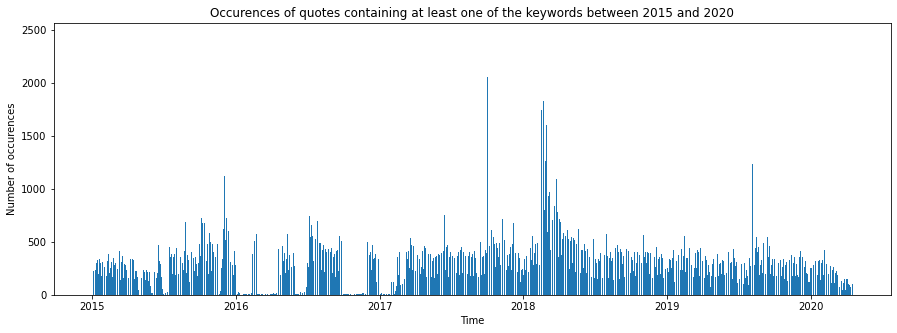

In [6]:
# Plotting number of quotes that contain keywords on the timeframe of the dataset
plt.figure(figsize=(15,5))

# We will use this in a comparitive plot in part 3
backup1 = df[['date','sum']]

plt.bar(df['date'],df['sum'])

plt.title('Occurences of quotes containing at least one of the keywords between 2015 and 2020')
plt.xlabel('Time')
plt.ylabel('Number of occurences')
plt.show()

In the end, we see that this is plot is extremly similar to what we have obtained in the previous histogram. This is probably what data science is about sometimes... But at least we have cleared a possible source of error out of the way. We will be using this specific dataframe in the rest of the analysis.

## 2 - Initial analysis of the "Mother Jone's" dataset

We have also proceeded to some initial analysis of the "Mother Jone's US Mass Shootings" dataset. Indeed, this dataset will give us some basic information about most shootings, such as: date, location, number of fatalities, number of injured, age of shooter, weapon type/legality...

In [7]:
# Reading the csv file
df = pd.read_csv('./Data/MassShootings.csv')

# Drop unrelevant columns (for our initial analysis)
# df = df.drop(columns = ['year', 'summary', 'prior_signs_mental_health_issues', 'mental_health_details', 'mental_health_sources', 'sources_additional_age', 'latitude', 'longitude'])

# Two new columns: location splitted into town and state
df[['town', 'state']] = df['location'].str.split(', ', expand = True)

# Convert date column to datetime format for better handling
df['date'] = pd.to_datetime(df['date'])

# Quotebank dataset is limited to years 2015-2021. Need to use same time span:
df = df.drop(df[df['date'].dt.year < 2015].index)
df = df.drop(df[df['date'].dt.year > 2020].index)

df.sample(n=1)

,case,location,date,summary,fatalities,injured,total_victims,location.1,age_of_shooter,prior_signs_mental_health_issues,...,gender,sources,mental_health_sources,sources_additional_age,latitude,longitude,type,year,town,state
24,Santa Fe High School shooting,"Santa Fe, Texas",2018-05-18,"Dimitrios Pagourtzis, a 17-year-old student, o...",10,13,23,School,17,-,...,M,https://www.chron.com/news/houston-texas/artic...,-,https://www.chron.com/news/houston-texas/artic...,29.392825,-95.141972,Mass,2018,Santa Fe,Texas


To give us a first glimpse at the data, we can plot the fatalities per shooting accross time, as well as the distribution of the number of fatalities per shooting.

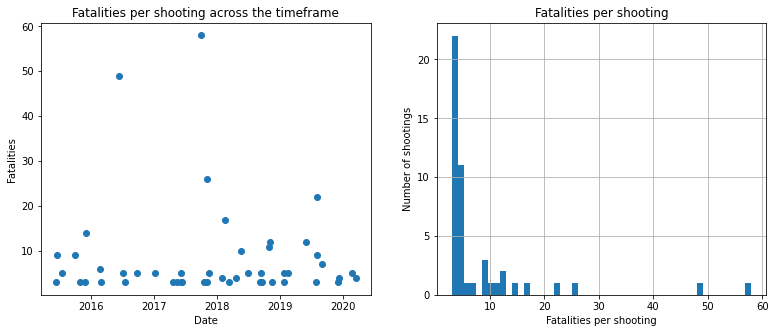

In [8]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

# Plot shootings in (time, number of fatalities) format
ax[0].scatter(df['date'], df['fatalities'])
ax[0].set_title('Fatalities per shooting across the timeframe')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Fatalities');

# Plot the distribution of the number of fatalities
ax[1] = df['fatalities'].hist(bins= 50)
ax[1].set_xlabel('Fatalities per shooting')
ax[1].set_ylabel('Number of shootings')
ax[1].set_title('Fatalities per shooting');

There isn't much data, but we can say it seems to follow a power law: most of the shootings have a small number of fatalities (<10), but some outliers are not unusual either, some shootings having over 40 fatalities.

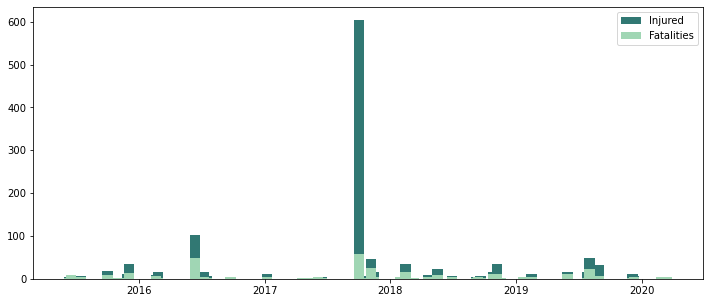

In [9]:
# The distribution of of fatalities, injured, total per month is plotted here
fig, ax = plt.subplots(figsize=(12, 5))
plt.bar(df['date'],df['total_victims'],width=30, color = '#317873')
plt.bar(df['date'],df['fatalities'],width=30, color = '#a0d6b4')
plt.legend(['Injured','Fatalities'])
plt.show()

There are many paramters to explore, and one of them is location of the event. With the following plot, we can clearly see that states have been very unequally affected by mass shootings. We can try to find some relevant correlations further on, such as average salary in the state, state political position (more of a 'blue state' or a 'red state'), etc. It will also be interesting to see how the location influences the media outrage after the shooting.

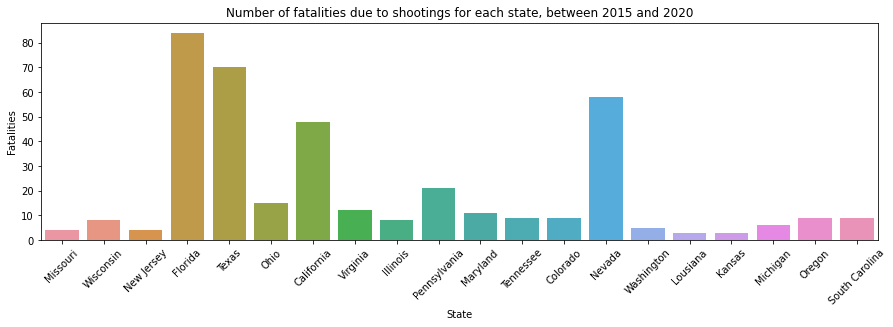

In [10]:
# Ploting the number of fatalities per state

fig, ax = plt.subplots(figsize=(15, 4))
ax = sns.barplot(y = df['fatalities'], x = df['state'], estimator = sum, ci = None)

ax.set_xlabel("State")
ax.set_ylabel("Fatalities")
ax.set_title("Number of fatalities due to shootings for each state, between 2015 and 2020")
plt.xticks(rotation=45)
plt.show()

We can also look at some key statistics, using the .decribe() function. INUTILE? IL ME SEMBLE AUSSI QU'ON SE CONCENTRE BEAUCOUP SUR LES FATALITIES ET PEU SUR LES AUTRES VARIABLES AUSSIN NON? 

In [11]:
df['fatalities'].describe()

count    48.000000
mean      8.250000
std      10.798936
min       3.000000
25%       3.000000
50%       5.000000
75%       9.000000
max      58.000000
Name: fatalities, dtype: float64

Finally, we will use this dataframe in comparitive plots in part 3. Therefore we save it to a new dataframe (in case we want to overwrite df further on):

In [12]:
backup2 = df[['date','fatalities']]

## 3 - Linking the two datasets

We will start by plotting a single timeline graph with the number of fatalities due to shootings over time, as well as the occurence of gun-related words in the media.

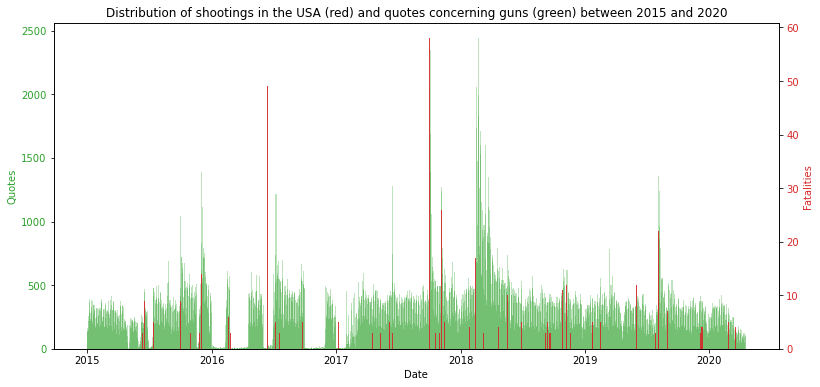

In [13]:
fig, ax1 = plt.subplots(figsize=(13,6))

# Plotting the quotes over time (green)
color = 'tab:green'
ax1.set_title('Distribution of shootings in the USA (red) and quotes concerning guns (green) between 2015 and 2020')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quotes', color=color)
ax1.bar(backup1['date'], backup1['sum'], color=color, alpha=0.3, width = 3)
ax1.tick_params(axis='y', labelcolor=color)

# Same x-axis, but different y axis
ax2 = ax1.twinx()

# Plotting the fatalities due to shootings over time (red)
color = 'tab:red'
ax2.set_ylabel('Fatalities', color=color)  # we already handled the x-label with ax1
ax2.bar(backup2['date'], backup2['fatalities'], color=color, alpha=0.9, width = 3)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

We can see several interesting events in this first plot. For example, the largest peak in fatalities happens around october 2017. It is followed by the second largest peak in quotes talking about guns.

In [14]:
# Print the largest shooting (most fatalities)
backup2 = backup2.sort_values(by='fatalities',ascending=False)
backup2 = backup2.reset_index(drop=True)
print("The largest shooting was:")
print(backup2.iloc[0])

# Quotes following the shooting (two days after)
backup1 = backup1.sort_values(by='sum',ascending=False)
print("\nThe corresponding peak in quotes discussing guns was:")
print(backup1.iloc[1])

The largest shooting was:
date          2017-10-01 00:00:00
fatalities                     58
Name: 0, dtype: object

The corresponding peak in quotes discussing guns was:
date    2017-10-03 00:00:00
sum                    2351
Name: 1, dtype: object


With the above print, we see that this peak is maximal exactly two days after the shooting.
 
Another interesting observation we can make is that the largest peak in quotes concerning guns takes place after a smaller shooting, in early 2018:

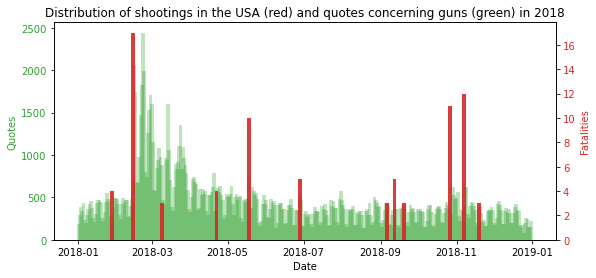

In [15]:
# We want to zoom in by looking only at 2018
backup1_2018 = backup1[(backup1['date'].dt.year==2018)]
backup2_2018 = backup2[(backup2['date'].dt.year==2018)]

fig, ax1 = plt.subplots(figsize=(9,4))

# Plotting the quotes over time (green barplot)
color = 'tab:green'
ax1.set_title('Distribution of shootings in the USA (red) and quotes concerning guns (green) in 2018')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quotes', color=color)
ax1.bar(backup1_2018['date'], backup1_2018['sum'], color=color, alpha=0.3, width = 3)
ax1.tick_params(axis='y', labelcolor=color)

# Same x-axis, but different y axis
ax2 = ax1.twinx()

# Plotting the fatalities due to shootings over time (red barplot)
color = 'tab:red'
ax2.set_ylabel('Fatalities', color=color)  # we already handled the x-label with ax1
ax2.bar(backup2_2018['date'], backup2_2018['fatalities'], color=color, alpha=0.9, width = 3)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

It seams that this particular event has made much more noise then the others and over a larger period of time. The fact that it was certainly not the shooting with the most fatalities ("only" 17, compared to 58 for the max) shows that the number of fatalities is clearly not the only parameter that influences the media coverage of the event as well as the amplitude of the discussion on gun control afterwards.

This makes us want to investigate further: what are the other factors that can explain these differences? Some ideas: 
- Location of the shooting (what state, but also what type of place: e.g. at a school, workplace...)
- Wheather of not the weapon was bought legally
- Age, gender and ethnicity of the shooter and/or the victims
- The type of weapon that was used (semi-automatic...)
- etc.

Just to give us an idea, we can look at the corresponding case in the dataframe and get all the details we know about it:

In [16]:
df = df[(df['date'].dt.year==2018)]
df = df.sort_values(by='fatalities', ascending=False)
df.iloc[0]

case                                    Marjory Stoneman Douglas High School shooting
location                                                            Parkland, Florida
date                                                              2018-02-14 00:00:00
summary                             Nikolas J. Cruz, 19, heavily armed with an AR-...
fatalities                                                                         17
injured                                                                            17
total_victims                                                                      34
location.1                                                                     School
age_of_shooter                                                                     19
prior_signs_mental_health_issues                                                  Yes
mental_health_details               Cruz had a long history of behavioral problems...
weapons_obtained_legally                              